In [1]:
from msms2haplo import *

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import os
import copy
import time
import numpy as np
import pandas as pd
import torch.nn.functional as F
from pathlib import Path

from tqdm import tqdm
from __future__ import print_function, division
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import models
import matplotlib.pyplot as plt

In [4]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import warnings
warnings.filterwarnings("ignore")

In [5]:
# Seed

import random
seed = 123
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

In [6]:
def myresize(chroms):
    chroms = torch.Tensor(chroms)
    if chroms.shape[1] >= 40:
        chroms = chroms[:,:40]
    else:
        snp_dim = chroms.shape[1]
        addzeros = 40 - snp_dim -1
        chroms = F.pad(chroms, (1, addzeros), "constant", 0)
    return chroms

In [7]:
class BalancingSelectionDataset(Dataset):
    """BalancingSelectionDataset dataset."""

    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    

In [8]:
class BalancingSelection2Dataset(Dataset):
    """BalancingSelectionDataset dataset."""

    def __init__(self, Xa, Xr, ya, yr):
        self.Xa = Xa
        self.ya = ya
        self.Xr = Xr
        self.yr = yr

    def __len__(self):
        return self.Xa.shape[0]

    def __getitem__(self, idx):
        return self.Xa[idx], self.Xr[idx], self.ya[idx], self.yr[idx]
    

In [9]:
def get_paths(directories):
    all_files = []
    for d in directories:
        path = Path(d)
        files = os.listdir(path)
        files = [path/file for file in files]
        all_files.append(files)
    return all_files

def ancient_files_to_X(files):

    Xs = []
    for i in range(len(files[0])):

        file_time0, file_time1, file_time2, file_time3 = files[0][i], files[1][i], files[2][i], files[3][i]
        files_timepoints = [file_time0, file_time1, file_time2, file_time3]

        matrices_timepoints = []
        for file in files_timepoints:

            chroms, positions = read_msms(filename=file, NCHROMS=10)
            chroms = sort_min_diff(chroms)
            matrices_timepoints.append(torch.Tensor(myresize(chroms)))

        Xs.append(torch.vstack(matrices_timepoints))


    X = torch.stack(Xs)
    X = X.unsqueeze(1)
    
    return X

In [10]:
directories =  ["neutral/1", "neutral/2", "neutral/3", "neutral/4", "neutral/5"]
files_neutral = get_paths(directories)

directories =  ["dominance0025/1", "dominance0025/2", "dominance0025/3", "dominance0025/4", "dominance0025/5"]
files_dominance0025 = get_paths(directories)

directories =  ["dominance05/1", "dominance05/2", "dominance05/3", "dominance05/4", "dominance05/5"]
files_dominance05 = get_paths(directories)

In [11]:
num_samples = 1000

Xa_neutral = ancient_files_to_X(files_neutral)
ya_neutral = torch.Tensor([0]*num_samples).long()

Xa_dominance0025 = ancient_files_to_X(files_dominance0025)
ya_dominance0025 = torch.Tensor([1]*num_samples).long()


Xa_dominance05 = ancient_files_to_X(files_dominance05)
ya_dominance05 = torch.Tensor([2]*num_samples).long()

In [12]:
Xa = torch.cat([Xa_neutral, Xa_dominance05, Xa_dominance0025], axis=0)
ya = torch.cat([ya_neutral, ya_dominance05, ya_dominance0025], axis=0)

In [13]:
def recent_files_to_X(files):

    Xs = []
    for i in range(len(files[4])):

        file_time = files[4][i]
        files_timepoints = [file_time]

        matrices_timepoints = []
        for file in files_timepoints:
            chroms, positions = read_msms(filename=file, NCHROMS=40)
            chroms = sort_min_diff(chroms)
            matrices_timepoints.append(torch.Tensor(myresize(chroms)))
       

        Xs.append(torch.vstack(matrices_timepoints))

    X = torch.stack(Xs)
    X = X.unsqueeze(1)
    
    return X

In [14]:
num_samples = 1000

Xr_neutral = recent_files_to_X(files_neutral)
yr_neutral = torch.Tensor([0]*num_samples).long()

Xr_dominance05 = recent_files_to_X(files_dominance05)
yr_dominance05 = torch.Tensor([2]*num_samples).long()

Xr_dominance0025 = recent_files_to_X(files_dominance0025)
yr_dominance0025 = torch.Tensor([1]*num_samples).long()

Xr = torch.cat([Xr_neutral, Xr_dominance05, Xr_dominance0025], axis=0)
yr = torch.cat([yr_neutral, yr_dominance05, yr_dominance0025], axis=0)

In [15]:
random_idx = np.random.choice(range(0,3000), 3000)

In [16]:
def get_dataloader(Xa, Xr, ya, yr):
    
    #split = 250
    split = 1000
    bs_val_dataset = BalancingSelection2Dataset(Xa[random_idx[0:split]], Xr[random_idx[0:split]], ya[random_idx[0:split]], yr[random_idx[0:split]])
    
    bs_train_dataset = BalancingSelection2Dataset(Xa[random_idx[split:]], Xr[random_idx[split:]], ya[random_idx[split:]], yr[random_idx[split:]])
    
    dataset_sizes = {}
    dataset_sizes["train"] = len(bs_train_dataset)
    dataset_sizes["val"] = len(bs_val_dataset)
    train_dl = torch.utils.data.DataLoader(bs_train_dataset, batch_size=16, shuffle=True, num_workers=4)
    val_dl = torch.utils.data.DataLoader(bs_val_dataset, batch_size=16, shuffle=True, num_workers=4)
    dataloaders = {"train":train_dl, "val":val_dl}
    return dataloaders, dataset_sizes

In [17]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [18]:
def ensemble_train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for Xa, Xr, ya, yr in dataloaders[phase]:
                
                Xa = Xa.to(device)
                Xr = Xr.to(device)
                ya = ya.to(device)
                yr = yr.to(device)
                
                #assert ya == yr

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(Xa, Xr)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, ya)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * Xa.size(0)
                running_corrects += torch.sum(preds == ya.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [19]:
def convnet():

    model = models.resnet18(pretrained=False)    
    model.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=False)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 3)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    
    return model

In [20]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [21]:
class TwoBranchEnsembleModel(nn.Module):
    def __init__(self, ancient_model, recent_model, nb_classes=2):
        super(TwoBranchEnsembleModel, self).__init__()
        
        self.ancient_model = ancient_model
        self.recent_model = recent_model
        
        input_size = num_output_layers_single_model+num_output_layers_single_model
        
        self.l0 = nn.Linear(input_size, input_size//2)
        self.l1 = nn.Linear(input_size//2, input_size//4)
        self.l2 = nn.Linear(input_size//4, nb_classes)

        
        
    def forward(self, ancient_data, recent_data):
        x0 = self.ancient_model(ancient_data)  
        x1 = self.recent_model(recent_data) 
        
        x = torch.cat((x0, x1), dim=1)
        
        x = self.l0(F.relu(x))
        x = self.l1(F.relu(x))
        x = self.l2(F.relu(x))
        
        return x
    
def create_convnet(num_output_layers=2):
    model = models.resnet18(pretrained=False)    
    model.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=False)
    model.fc = nn.Linear(model.fc.in_features, num_output_layers)
    return model
    


# ancient and recent model

In [22]:

confusion_matrices_both_recent_ancient = []

for _ in tqdm(range(10)):

    # get dataloaders
    dataloaders, dataset_sizes = get_dataloader(Xa, Xr, ya, yr)
    
    # prepare ensemble model
    num_output_layers_single_model = 64
    ancient_model = create_convnet(num_output_layers=num_output_layers_single_model)
    recent_model = create_convnet(num_output_layers=num_output_layers_single_model)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = TwoBranchEnsembleModel(ancient_model, recent_model, nb_classes=3).to(device)

    # prepare training
    criterion = nn.CrossEntropyLoss()
    optimizer_ft = optim.Adam(model.parameters(), lr=0.00005)
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

    
    # train for 3 epochs
    model = ensemble_train_model(model, criterion, optimizer_ft, exp_lr_scheduler,num_epochs=3)


    # validate
    y_hat = []
    y_true = []
    with torch.no_grad():
        for Xba, Xbr, yba, ybr in dataloaders["val"]:
            Xba = Xba.to(device)
            Xbr = Xbr.to(device)
            yba = yba.to(device)
            ybr = ybr.to(device)
            outputs = model(Xba, Xbr)
            _, preds = torch.max(outputs, 1)
            y_hat += preds.cpu().numpy().tolist()
            y_true += yba.cpu().numpy().tolist()


    # save confusion
    cm = confusion_matrix(y_true, y_hat)
    cm = cm / cm.sum(1)

    confusion_matrices_both_recent_ancient.append(cm)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0/2
----------
train Loss: 0.9321 Acc: 0.5835
val Loss: 0.6528 Acc: 0.6540

Epoch 1/2
----------
train Loss: 0.5196 Acc: 0.7770
val Loss: 0.4738 Acc: 0.8190

Epoch 2/2
----------
train Loss: 0.2382 Acc: 0.9370
val Loss: 0.3833 Acc: 0.8350

Training complete in 0m 20s
Best val Acc: 0.835000


 10%|█         | 1/10 [00:24<03:44, 24.92s/it]

Epoch 0/2
----------
train Loss: 0.9611 Acc: 0.5800
val Loss: 0.7080 Acc: 0.7530

Epoch 1/2
----------
train Loss: 0.4690 Acc: 0.8545
val Loss: 0.4077 Acc: 0.8300

Epoch 2/2
----------
train Loss: 0.0977 Acc: 0.9865
val Loss: 0.3690 Acc: 0.8550

Training complete in 0m 20s
Best val Acc: 0.855000


 20%|██        | 2/10 [00:45<03:00, 22.57s/it]

Epoch 0/2
----------
train Loss: 0.9571 Acc: 0.5310
val Loss: 0.6978 Acc: 0.6550

Epoch 1/2
----------
train Loss: 0.5675 Acc: 0.7620
val Loss: 0.4933 Acc: 0.8320

Epoch 2/2
----------
train Loss: 0.2743 Acc: 0.9270
val Loss: 0.3961 Acc: 0.8410

Training complete in 0m 20s
Best val Acc: 0.841000


 30%|███       | 3/10 [01:07<02:33, 21.98s/it]

Epoch 0/2
----------
train Loss: 0.9575 Acc: 0.6045
val Loss: 0.6932 Acc: 0.7210

Epoch 1/2
----------
train Loss: 0.5143 Acc: 0.8095
val Loss: 0.4646 Acc: 0.8070

Epoch 2/2
----------
train Loss: 0.2113 Acc: 0.9370
val Loss: 0.4207 Acc: 0.8220

Training complete in 0m 20s
Best val Acc: 0.822000


 40%|████      | 4/10 [01:28<02:09, 21.63s/it]

Epoch 0/2
----------
train Loss: 0.9563 Acc: 0.6205
val Loss: 0.6926 Acc: 0.7390

Epoch 1/2
----------
train Loss: 0.4332 Acc: 0.8705
val Loss: 0.4136 Acc: 0.8280

Epoch 2/2
----------
train Loss: 0.1063 Acc: 0.9800
val Loss: 0.3993 Acc: 0.8260

Training complete in 0m 20s
Best val Acc: 0.828000


 50%|█████     | 5/10 [01:49<01:47, 21.43s/it]

Epoch 0/2
----------
train Loss: 0.9753 Acc: 0.5115
val Loss: 0.6747 Acc: 0.7430

Epoch 1/2
----------
train Loss: 0.4807 Acc: 0.8455
val Loss: 0.4360 Acc: 0.8170

Epoch 2/2
----------
train Loss: 0.1308 Acc: 0.9730
val Loss: 0.3680 Acc: 0.8430

Training complete in 0m 20s
Best val Acc: 0.843000


 60%|██████    | 6/10 [02:10<01:25, 21.44s/it]

Epoch 0/2
----------
train Loss: 0.9547 Acc: 0.5745
val Loss: 0.7957 Acc: 0.5800

Epoch 1/2
----------
train Loss: 0.6870 Acc: 0.6345
val Loss: 0.6299 Acc: 0.6680

Epoch 2/2
----------
train Loss: 0.4451 Acc: 0.8645
val Loss: 0.4728 Acc: 0.8240

Training complete in 0m 20s
Best val Acc: 0.824000


 70%|███████   | 7/10 [02:32<01:04, 21.41s/it]

Epoch 0/2
----------
train Loss: 0.9526 Acc: 0.5285
val Loss: 0.6700 Acc: 0.6750

Epoch 1/2
----------
train Loss: 0.4053 Acc: 0.8875
val Loss: 0.3975 Acc: 0.8340

Epoch 2/2
----------
train Loss: 0.0843 Acc: 0.9855
val Loss: 0.4047 Acc: 0.8280

Training complete in 0m 20s
Best val Acc: 0.834000


 80%|████████  | 8/10 [02:53<00:42, 21.46s/it]

Epoch 0/2
----------
train Loss: 1.0112 Acc: 0.5560
val Loss: 0.7615 Acc: 0.7020

Epoch 1/2
----------
train Loss: 0.4269 Acc: 0.9110
val Loss: 0.4967 Acc: 0.7850

Epoch 2/2
----------
train Loss: 0.1060 Acc: 0.9780
val Loss: 0.4117 Acc: 0.8120

Training complete in 0m 20s
Best val Acc: 0.812000


 90%|█████████ | 9/10 [03:15<00:21, 21.55s/it]

Epoch 0/2
----------
train Loss: 0.9349 Acc: 0.5680
val Loss: 0.7229 Acc: 0.6690

Epoch 1/2
----------
train Loss: 0.5072 Acc: 0.8200
val Loss: 0.4235 Acc: 0.8280

Epoch 2/2
----------
train Loss: 0.1618 Acc: 0.9720
val Loss: 0.3673 Acc: 0.8470

Training complete in 0m 21s
Best val Acc: 0.847000


100%|██████████| 10/10 [03:37<00:00, 21.77s/it]


# ancient model training

In [23]:

split = 1000
bs_val_dataset = BalancingSelectionDataset(Xa[random_idx[0:split]], ya[random_idx[0:split]])
bs_train_dataset = BalancingSelectionDataset(Xa[random_idx[split:]], ya[random_idx[split:]])
dataset_sizes = {}
dataset_sizes["train"] = len(bs_train_dataset)
dataset_sizes["val"] = len(bs_val_dataset)
train_dl = torch.utils.data.DataLoader(bs_train_dataset, batch_size=16, shuffle=True, num_workers=4)
val_dl = torch.utils.data.DataLoader(bs_val_dataset, batch_size=16, shuffle=True, num_workers=4)
dataloaders = {"train":train_dl, "val":val_dl}



confusion_matrices_ancient = []

for _ in tqdm(range(10)):

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = convnet().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer_ft = optim.Adam(model.parameters(), lr=0.00005)
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
    model = train_model(model, criterion, optimizer_ft, exp_lr_scheduler,num_epochs=3)
    
    y_hat = []
    y_true = []
    with torch.no_grad():
        for Xb, yb in dataloaders["val"]:

            Xb = Xb.to(device)
            yb = yb.to(device)

            outputs = model(Xb)
            _, preds = torch.max(outputs, 1)

            y_hat += preds.cpu().numpy().tolist()
            y_true += yb.cpu().numpy().tolist()
            
            
    cm = confusion_matrix(y_true, y_hat)
    cm = cm / cm.sum(1)
    confusion_matrices_ancient.append(cm)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0/2
----------
train Loss: 0.7918 Acc: 0.6340
val Loss: 0.5988 Acc: 0.7320

Epoch 1/2
----------
train Loss: 0.1724 Acc: 0.9585
val Loss: 0.4981 Acc: 0.7950

Epoch 2/2
----------
train Loss: 0.0347 Acc: 0.9980
val Loss: 0.5128 Acc: 0.8040

Training complete in 0m 11s
Best val Acc: 0.804000


 10%|█         | 1/10 [00:11<01:47, 11.91s/it]

Epoch 0/2
----------
train Loss: 0.7949 Acc: 0.6245
val Loss: 0.5727 Acc: 0.7690

Epoch 1/2
----------
train Loss: 0.1874 Acc: 0.9485
val Loss: 0.5749 Acc: 0.7550

Epoch 2/2
----------
train Loss: 0.0352 Acc: 0.9965
val Loss: 0.6136 Acc: 0.7770

Training complete in 0m 11s
Best val Acc: 0.777000


 20%|██        | 2/10 [00:24<01:37, 12.15s/it]

Epoch 0/2
----------
train Loss: 0.8074 Acc: 0.6095
val Loss: 0.5444 Acc: 0.7820

Epoch 1/2
----------
train Loss: 0.1910 Acc: 0.9555
val Loss: 0.5423 Acc: 0.7610

Epoch 2/2
----------
train Loss: 0.0381 Acc: 0.9975
val Loss: 0.5497 Acc: 0.7890

Training complete in 0m 11s
Best val Acc: 0.789000


 30%|███       | 3/10 [00:36<01:25, 12.20s/it]

Epoch 0/2
----------
train Loss: 0.8206 Acc: 0.6070
val Loss: 0.5282 Acc: 0.7780

Epoch 1/2
----------
train Loss: 0.1839 Acc: 0.9530
val Loss: 0.5009 Acc: 0.7680

Epoch 2/2
----------
train Loss: 0.0361 Acc: 0.9965
val Loss: 0.5290 Acc: 0.7740

Training complete in 0m 11s
Best val Acc: 0.778000


 40%|████      | 4/10 [00:48<01:12, 12.10s/it]

Epoch 0/2
----------
train Loss: 0.7968 Acc: 0.6280
val Loss: 0.5324 Acc: 0.7930

Epoch 1/2
----------
train Loss: 0.1808 Acc: 0.9610
val Loss: 0.5039 Acc: 0.7910

Epoch 2/2
----------
train Loss: 0.0363 Acc: 0.9970
val Loss: 0.5897 Acc: 0.7830

Training complete in 0m 11s
Best val Acc: 0.793000


 50%|█████     | 5/10 [01:00<01:00, 12.04s/it]

Epoch 0/2
----------
train Loss: 0.8294 Acc: 0.6225
val Loss: 0.5423 Acc: 0.7520

Epoch 1/2
----------
train Loss: 0.1909 Acc: 0.9565
val Loss: 0.5344 Acc: 0.7570

Epoch 2/2
----------
train Loss: 0.0362 Acc: 0.9980
val Loss: 0.5861 Acc: 0.7770

Training complete in 0m 11s
Best val Acc: 0.777000


 60%|██████    | 6/10 [01:12<00:48, 12.04s/it]

Epoch 0/2
----------
train Loss: 0.7863 Acc: 0.6395
val Loss: 0.5347 Acc: 0.7660

Epoch 1/2
----------
train Loss: 0.1797 Acc: 0.9605
val Loss: 0.5055 Acc: 0.7670

Epoch 2/2
----------
train Loss: 0.0298 Acc: 0.9980
val Loss: 0.5405 Acc: 0.7880

Training complete in 0m 11s
Best val Acc: 0.788000


 70%|███████   | 7/10 [01:24<00:36, 12.02s/it]

Epoch 0/2
----------
train Loss: 0.7919 Acc: 0.6420
val Loss: 0.5357 Acc: 0.7750

Epoch 1/2
----------
train Loss: 0.1930 Acc: 0.9520
val Loss: 0.5489 Acc: 0.7730

Epoch 2/2
----------
train Loss: 0.0332 Acc: 0.9975
val Loss: 0.5157 Acc: 0.7970

Training complete in 0m 11s
Best val Acc: 0.797000


 80%|████████  | 8/10 [01:36<00:24, 12.02s/it]

Epoch 0/2
----------
train Loss: 0.8092 Acc: 0.6205
val Loss: 0.5629 Acc: 0.7650

Epoch 1/2
----------
train Loss: 0.1748 Acc: 0.9610
val Loss: 0.5010 Acc: 0.7810

Epoch 2/2
----------
train Loss: 0.0304 Acc: 0.9985
val Loss: 0.5239 Acc: 0.7890

Training complete in 0m 11s
Best val Acc: 0.789000


 90%|█████████ | 9/10 [01:48<00:12, 12.01s/it]

Epoch 0/2
----------
train Loss: 0.7899 Acc: 0.6325
val Loss: 0.5729 Acc: 0.7750

Epoch 1/2
----------
train Loss: 0.1890 Acc: 0.9570
val Loss: 0.5381 Acc: 0.7610

Epoch 2/2
----------
train Loss: 0.0381 Acc: 0.9980
val Loss: 0.5745 Acc: 0.7770

Training complete in 0m 11s
Best val Acc: 0.777000


100%|██████████| 10/10 [02:00<00:00, 12.05s/it]


# recent model

In [24]:
split = 1000
bs_val_dataset = BalancingSelectionDataset(Xr[random_idx[0:split]], yr[random_idx[0:split]])
bs_train_dataset = BalancingSelectionDataset(Xr[random_idx[split:]], yr[random_idx[split:]])
dataset_sizes = {}
dataset_sizes["train"] = len(bs_train_dataset)
dataset_sizes["val"] = len(bs_val_dataset)
train_dl = torch.utils.data.DataLoader(bs_train_dataset, batch_size=16, shuffle=True, num_workers=4)
val_dl = torch.utils.data.DataLoader(bs_val_dataset, batch_size=16, shuffle=True, num_workers=4)
dataloaders = {"train":train_dl, "val":val_dl}

In [25]:
confusion_matrices_recent = []

for _ in tqdm(range(10)):

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = convnet().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer_ft = optim.Adam(model.parameters(), lr=0.00005)
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
    model = train_model(model, criterion, optimizer_ft, exp_lr_scheduler,num_epochs=3)
    
    
    y_hat = []
    y_true = []
    with torch.no_grad():
        for Xb, yb in dataloaders["val"]:
            Xb = Xb.to(device)
            yb = yb.to(device)
            outputs = model(Xb)
            _, preds = torch.max(outputs, 1)
            y_hat += preds.cpu().numpy().tolist()
            y_true += yb.cpu().numpy().tolist()
            
    cm = confusion_matrix(y_true, y_hat)
    cm = cm / cm.sum(1)
    confusion_matrices_recent.append(cm)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0/2
----------
train Loss: 0.7278 Acc: 0.6450
val Loss: 0.4962 Acc: 0.7760

Epoch 1/2
----------
train Loss: 0.2024 Acc: 0.9500
val Loss: 0.4843 Acc: 0.8010

Epoch 2/2
----------
train Loss: 0.0475 Acc: 0.9920
val Loss: 0.5144 Acc: 0.8040

Training complete in 0m 12s
Best val Acc: 0.804000


 10%|█         | 1/10 [00:12<01:55, 12.83s/it]

Epoch 0/2
----------
train Loss: 0.7156 Acc: 0.6690
val Loss: 0.5075 Acc: 0.7880

Epoch 1/2
----------
train Loss: 0.1969 Acc: 0.9525
val Loss: 0.4897 Acc: 0.7850

Epoch 2/2
----------
train Loss: 0.0437 Acc: 0.9945
val Loss: 0.5526 Acc: 0.7870

Training complete in 0m 13s
Best val Acc: 0.788000


 20%|██        | 2/10 [00:26<01:45, 13.21s/it]

Epoch 0/2
----------
train Loss: 0.7259 Acc: 0.6515
val Loss: 0.5259 Acc: 0.7760

Epoch 1/2
----------
train Loss: 0.2236 Acc: 0.9415
val Loss: 0.4940 Acc: 0.7740

Epoch 2/2
----------
train Loss: 0.0547 Acc: 0.9900
val Loss: 0.5980 Acc: 0.7810

Training complete in 0m 12s
Best val Acc: 0.781000


 30%|███       | 3/10 [00:39<01:32, 13.16s/it]

Epoch 0/2
----------
train Loss: 0.7110 Acc: 0.6555
val Loss: 0.5329 Acc: 0.7560

Epoch 1/2
----------
train Loss: 0.2267 Acc: 0.9400
val Loss: 0.4663 Acc: 0.7990

Epoch 2/2
----------
train Loss: 0.0448 Acc: 0.9960
val Loss: 0.5225 Acc: 0.7970

Training complete in 0m 11s
Best val Acc: 0.799000


 40%|████      | 4/10 [00:51<01:16, 12.74s/it]

Epoch 0/2
----------
train Loss: 0.7343 Acc: 0.6475
val Loss: 0.5095 Acc: 0.7900

Epoch 1/2
----------
train Loss: 0.2010 Acc: 0.9565
val Loss: 0.4892 Acc: 0.7940

Epoch 2/2
----------
train Loss: 0.0533 Acc: 0.9925
val Loss: 0.5460 Acc: 0.7970

Training complete in 0m 12s
Best val Acc: 0.797000


 50%|█████     | 5/10 [01:04<01:03, 12.66s/it]

Epoch 0/2
----------
train Loss: 0.7308 Acc: 0.6550
val Loss: 0.5274 Acc: 0.7730

Epoch 1/2
----------
train Loss: 0.2151 Acc: 0.9410
val Loss: 0.4716 Acc: 0.7930

Epoch 2/2
----------
train Loss: 0.0427 Acc: 0.9920
val Loss: 0.5009 Acc: 0.8020

Training complete in 0m 11s
Best val Acc: 0.802000


 60%|██████    | 6/10 [01:16<00:49, 12.46s/it]

Epoch 0/2
----------
train Loss: 0.7206 Acc: 0.6530
val Loss: 0.5062 Acc: 0.7740

Epoch 1/2
----------
train Loss: 0.2136 Acc: 0.9420
val Loss: 0.4768 Acc: 0.7900

Epoch 2/2
----------
train Loss: 0.0518 Acc: 0.9920
val Loss: 0.4850 Acc: 0.7950

Training complete in 0m 11s
Best val Acc: 0.795000


 70%|███████   | 7/10 [01:28<00:37, 12.40s/it]

Epoch 0/2
----------
train Loss: 0.7321 Acc: 0.6385
val Loss: 0.4979 Acc: 0.7670

Epoch 1/2
----------
train Loss: 0.2086 Acc: 0.9450
val Loss: 0.5186 Acc: 0.7940

Epoch 2/2
----------
train Loss: 0.0570 Acc: 0.9920
val Loss: 0.4791 Acc: 0.8060

Training complete in 0m 11s
Best val Acc: 0.806000


 80%|████████  | 8/10 [01:40<00:24, 12.29s/it]

Epoch 0/2
----------
train Loss: 0.7518 Acc: 0.6340
val Loss: 0.5217 Acc: 0.7720

Epoch 1/2
----------
train Loss: 0.2308 Acc: 0.9355
val Loss: 0.4800 Acc: 0.7880

Epoch 2/2
----------
train Loss: 0.0541 Acc: 0.9920
val Loss: 0.5206 Acc: 0.7840

Training complete in 0m 11s
Best val Acc: 0.788000


 90%|█████████ | 9/10 [01:52<00:12, 12.23s/it]

Epoch 0/2
----------
train Loss: 0.7421 Acc: 0.6390
val Loss: 0.4967 Acc: 0.7870

Epoch 1/2
----------
train Loss: 0.2164 Acc: 0.9440
val Loss: 0.4656 Acc: 0.7980

Epoch 2/2
----------
train Loss: 0.0452 Acc: 0.9915
val Loss: 0.5405 Acc: 0.8050

Training complete in 0m 11s
Best val Acc: 0.805000


100%|██████████| 10/10 [02:04<00:00, 12.47s/it]


In [40]:
def plot_confusion_matrix(confusion_matrices, ax):

    bootstrap_cm = np.array(confusion_matrices).mean(0)
    bootstrap_stds = np.array(confusion_matrices).std(0)

    # standard deviation labels
    accuracies = [str(np.round(v, 2)) for v in bootstrap_cm.flatten().tolist()]
    stds = [str(np.round(v, 2)) for v in bootstrap_stds.flatten().tolist()]
    labels = [a  + "±\n" + s for a, s in zip(accuracies, stds)]
    labels = np.array(labels).reshape(3,3)
    
    sns.heatmap(bootstrap_cm, annot = labels, fmt = '', cmap="Blues", ax=ax, xticklabels=["N", "D0.25", "D0.5"], yticklabels=["N", "D0.25", "D0.5"], linecolor='black', linewidths=.5)

    ax.axhline(y=0, color='k',linewidth=5)
    ax.axhline(y=3, color='k',linewidth=5)
    ax.axvline(x=0, color='k',linewidth=5)
    ax.axvline(x=3, color='k',linewidth=5)


torch.save(confusion_matrices_ancient, "confusion_matrices_ancient.pth")
torch.save(confusion_matrices_recent, "confusion_matrices_recent.pth")
torch.save(confusion_matrices_both_recent_ancient, "confusion_matrices_both_recent_ancient.pth")

In [7]:
confusion_matrices_ancient = torch.load("confusion_matrices_ancient.pth")
confusion_matrices_recent = torch.load("confusion_matrices_recent.pth")
confusion_matrices_both_recent_ancient = torch.load("confusion_matrices_both_recent_ancient.pth")

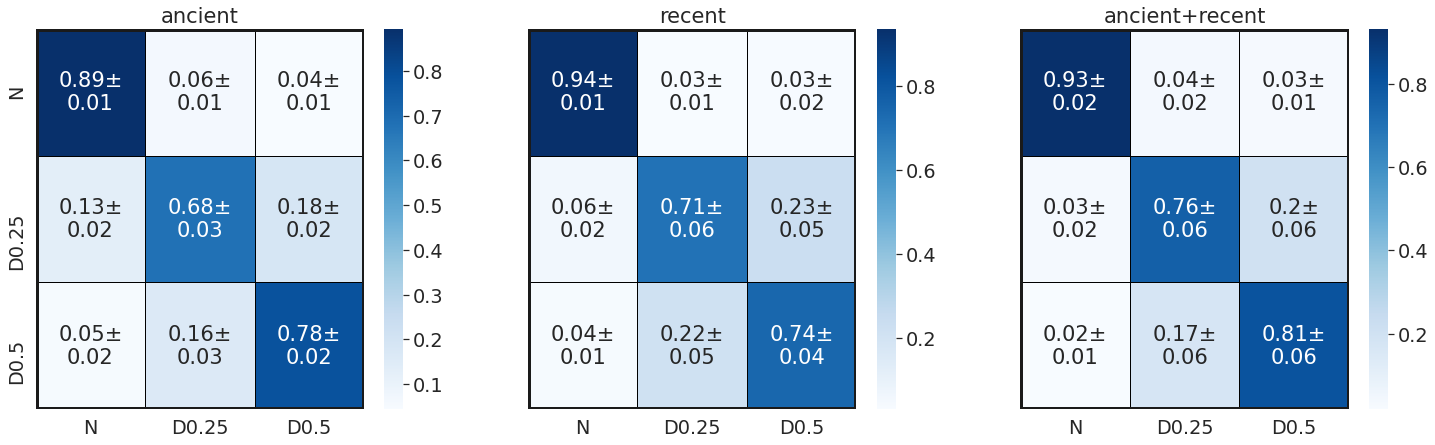

In [42]:
sns.set(style="white", font_scale=1.75)

fig, axs = plt.subplots(1,3 , sharex=True, sharey=True, figsize=(25, 7))

plot_confusion_matrix(confusion_matrices_ancient, axs[0])
plot_confusion_matrix(confusion_matrices_recent, axs[1])
plot_confusion_matrix(confusion_matrices_both_recent_ancient, axs[2])

axs[0].set_title("ancient")
axs[1].set_title("recent")
axs[2].set_title("ancient+recent")

plt.savefig("confusion_matrices_balancing_selection_with_std2_fix.png", dpi=600)